In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from utils import create_trajectories, get_trajectory_embedding, perform_clustering_and_plot
from data.makeSeaquestdata import load_seaquest_dataset
from data.makeHalfcheetahdata import load_halfcheetah_dataset
from load_model import load_seaquest_model, load_halfcheetah_model

No module named 'flow'
No module named 'carla'


In [2]:
device = "cpu"
random_seed = 0
np.random.seed(0)
torch.manual_seed(0)

In [3]:
seaquestdata, env = load_seaquest_dataset(env_name='Seaquest', size=25)
pre_trained_encoder_seaquest = load_seaquest_model("decision_transformer_atari/checkpoints/Seaquest_123.pth", seed=0)
# Seaquest data
final_obs_sq, final_act_sq, final_rew_sq, _ = create_trajectories(
    seaquestdata["observations"], seaquestdata["actions"], 
    seaquestdata["rewards"], seaquestdata["terminals"], trajectory_length=30
)
trajectory_embedding_seaquest = get_trajectory_embedding(
    pre_trained_encoder_seaquest, final_obs_sq, final_act_sq, final_rew_sq, 
    is_seaquest=True, device= device
)

Dataset loaded
Dataset extracted with 23608 samples.
Information about the dataset:
Observation shape:  (23608, 4, 84, 84)
Action shape:  (23608,)
Reward shape:  (23608,)
Terminal shape:  (23608,)
Action space:  18
Observation space:  (84, 84)
Number of terminal states is... 24
Environment 'ALE/Seaquest-ram-v5' initialized.


Processing trajectories:   0%|          | 0/799 [00:00<?, ?it/s]c:\Users\tgome\Desktop\FACT\factvenv\lib\site-packages\torch\cuda\amp\autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
Processing trajectories: 100%|██████████| 799/799 [00:23<00:00, 34.07it/s]


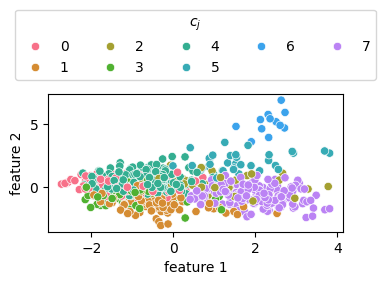

In [4]:
clusters_seaquest, traj_cluster_labels = perform_clustering_and_plot(trajectory_embedding_seaquest.detach().cpu().numpy(), 2, 8, plot=True)

In [ ]:

def meaningful_clusters(final_obs_sq, traj_cluster_labels, amount_clusters=8):

    """
    Calculate and visualize the average amount of times the submarine filled up the oxygen tank,
    exploded, and fought per cluster.

    Parameters:
    - final_obs_sq (list): List of observed sequences for each trajectory.
    - traj_cluster_labels (list): List of cluster labels for each trajectory.
    - amount_clusters (int): Number of clusters.

    Returns:
    None
    """

    def count_consecutive_occurrences_np(arr):
        
        # Calculate differences between adjacent elements to find where values change
        diffs = np.diff(arr)
        
        # Identify the indices where changes occur
        change_indices = np.where(diffs != 0)[0] + 1
        
        # Include the start and end of the array to identify all segments
        segments = np.concatenate(([0], change_indices, [len(arr)]))
        
        # Calculate segment lengths by differencing the indices
        segment_lengths = np.diff(segments)
        
        # Count segments with length greater than 10
        count = np.sum(segment_lengths >= 10)
        
        return count

        

    def count_increases_numpy(arr):

        # Find differences between consecutive elements
        diffs = np.diff(arr)

        # Identify where the differences are positive (indicating an increase)
        positive_diffs = diffs > 0

        # Find where the transitions from non-positive to positive differences occur
        increase_starts = np.diff(positive_diffs.astype(int)) == 1

        # Count the number of such transitions
        increase_count = np.sum(increase_starts)

        # If the very first element of 'positive_diffs' is True, count that as an increase as well
        if positive_diffs[0]:
            increase_count += 1

        return increase_count
    
    # Check the percentage of filing up  the tank per cluster
    cluster_attribution_filling_tank = {i: [] for i in range(amount_clusters)}
    cluster_attribution_explosion = {i: [] for i in range(amount_clusters)}
    cluster_attribution_fighting = {i: [] for i in range(amount_clusters)}
    for traj_id in range(len(final_obs_sq)):
        list_of_white_pixels = np.zeros(len(final_obs_sq[traj_id]))
        list_of_fighting_pixels = np.zeros(len(final_obs_sq[traj_id]))
        for ind, obs_values in enumerate(final_obs_sq[traj_id]):
            amount_white_pixels = len(np.where(obs_values[0] == 214)[0]) # 214 is the value for the oxygene tank (light color)
            explotion_pixels = 1 if len(np.where(obs_values[0] == 85)[0]) == 69 else 0# 85 is the color value for the explotion (no more oxygene tank) (gray color) when there are 69 pixels of that color it means that the explotion is happening
            try:
                fighting_pixels = 1 if np.where(obs_values[0] == 172)[0][0] <= 30 else 0 # 172 is the color of the submarine if this pixel is in the first 30 pixels of the image it means that the submarine is fighting in top of image.
            except:
                fighting_pixels = 0 # if the submarine is not in the image (for exmaple black screen) then it is not fighting
            
            list_of_white_pixels[ind] = amount_white_pixels
            list_of_fighting_pixels[ind] = fighting_pixels
        increase_count = count_increases_numpy(list_of_white_pixels)
        fighting_count = count_consecutive_occurrences_np(list_of_fighting_pixels)
        cluster_attribution_filling_tank[traj_cluster_labels[traj_id]].append(increase_count)
        cluster_attribution_explosion[traj_cluster_labels[traj_id]].append(explotion_pixels)
        cluster_attribution_fighting[traj_cluster_labels[traj_id]].append(fighting_count)

    average_attributions = {key: sum(values) / len(values) if len(values) > 0 else 0 for key, values in cluster_attribution_filling_tank.items()}
    names = list(average_attributions.keys())
    values = list(average_attributions.values())
    plt.bar(range(len(average_attributions)), values, tick_label=names)
    plt.title('Average amount of times the submarine filled up oxygene tank per cluster')
    plt.xlabel('Cluster id')
    plt.ylabel('Average amount of times the submarine filled up oxygene tank')
    plt.show()

    average_attributions = {key: sum(values) / len(values) if len(values) > 0 else 0 for key, values in cluster_attribution_explosion.items()}
    names = list(average_attributions.keys())
    values = list(average_attributions.values())
    plt.bar(range(len(average_attributions)), values, tick_label=names)
    plt.title('Average amount of times the submarine explosed per cluster')
    plt.xlabel('Cluster id')
    plt.ylabel('Average amount of times the submarine exploded')
    plt.show()

    average_attributions = {key: sum(values) / len(values) if len(values) > 0 else 0 for key, values in cluster_attribution_fighting.items()}
    names = list(average_attributions.keys())
    values = list(average_attributions.values())
    plt.bar(range(len(average_attributions)), values, tick_label=names)
    plt.title('Average amount of times the submarine is fighting per cluster')
    plt.xlabel('Cluster id')
    plt.ylabel('Average amount of times the submarine is fighting')
    plt.show()

    return

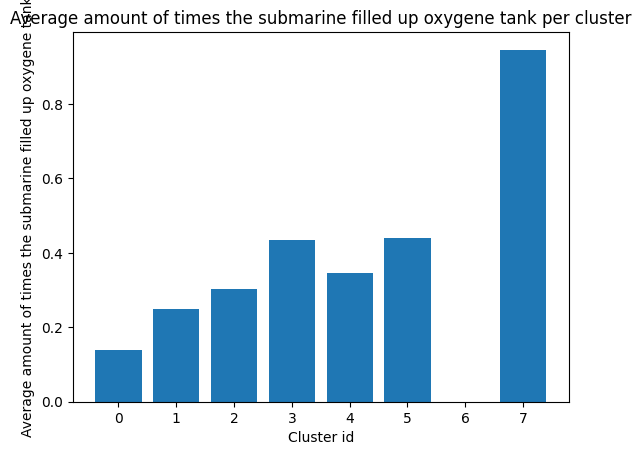

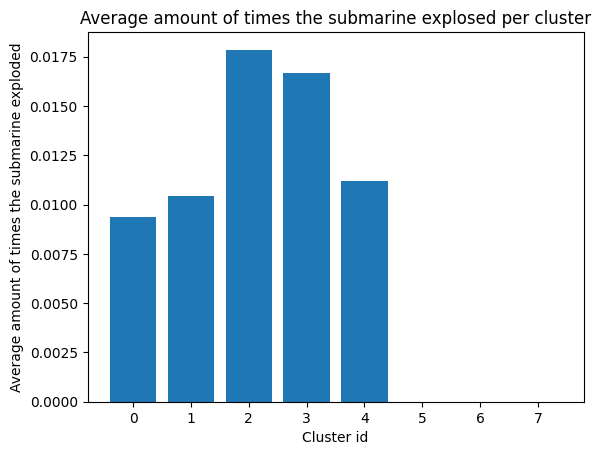

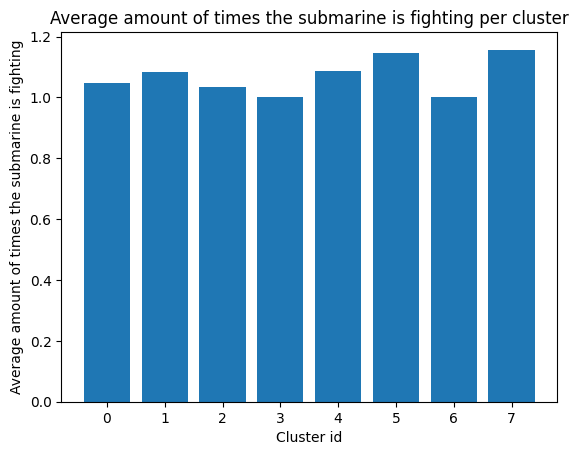

In [8]:
meaningful_clusters(final_obs_sq, traj_cluster_labels, amount_clusters=8)

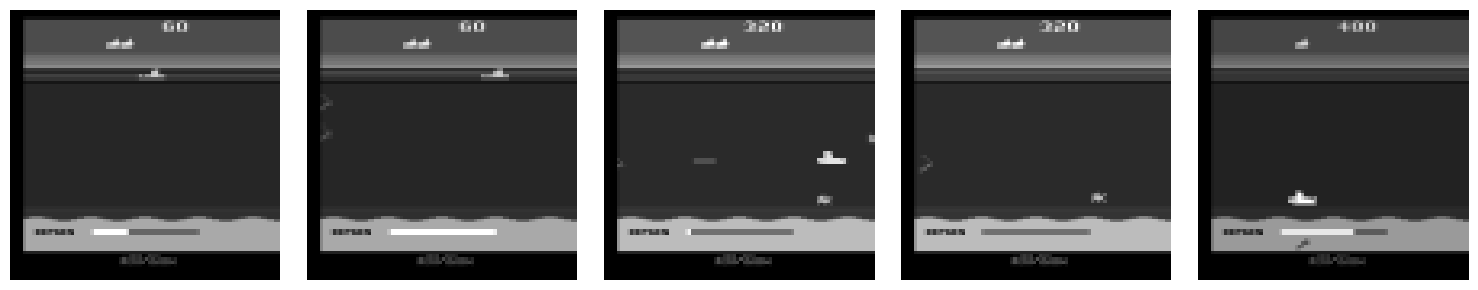

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

for ax, idx in zip(axes, clusters_seaquest[7][5:10]):
    ax.imshow(final_obs_sq[idx][0][0], cmap='gray')
    ax.axis('off')  # Hide axes for a cleaner look

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

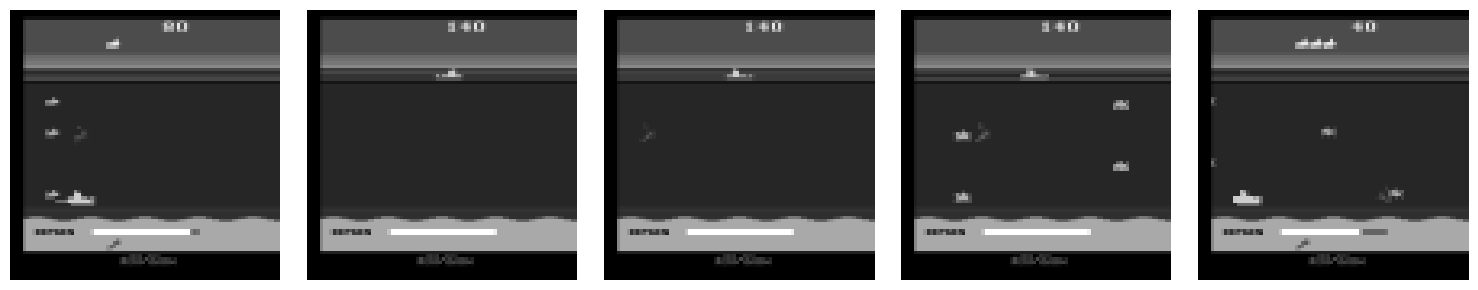

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

for ax, idx in zip(axes, clusters_seaquest[2][5:10]):
    ax.imshow(final_obs_sq[idx][0][0], cmap='gray')
    ax.axis('off')  # Hide axes for a cleaner look

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

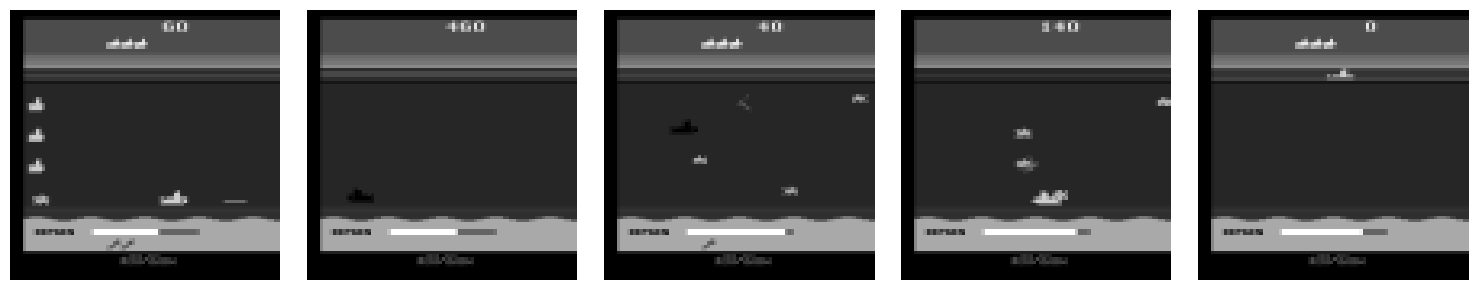

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

for ax, idx in zip(axes, clusters_seaquest[5][5:10]):
    ax.imshow(final_obs_sq[idx][0][0], cmap='gray')
    ax.axis('off')  # Hide axes for a cleaner look

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

In [10]:
import sys
sys.path.insert(0, 'trajectory_transformer')

halfcheetahdata, env = load_halfcheetah_dataset(env_name='halfcheetah-medium-v2', size=100*100, seed=0)
pre_trained_encoder_halfcheetah = load_halfcheetah_model("trajectory_transformer/logs/halfcheetah-medium-v2/gpt/pretrained", seed=0)

final_obs_hc, final_act_hc, final_rew_hc, final_ter_hc = create_trajectories(
    halfcheetahdata["observations"], halfcheetahdata["actions"], 
    halfcheetahdata["rewards"], halfcheetahdata["terminals"], trajectory_length=25
)

trajectory_embedding_halfcheetah = get_trajectory_embedding(
    pre_trained_encoder_halfcheetah, final_obs_hc, final_act_hc, final_rew_hc, is_seaquest=False, device = device
)

c:\Users\tgome\Desktop\FACT\factvenv\lib\site-packages\gym\spaces\box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile:   0%|          | 0/21 [00:00<?, ?it/s]

Processing sub'trajectories: 100%|█████████▉| 9999/10000 [00:00<00:00, 10438.42it/s]
c:\Users\tgome\Desktop\FACT\factvenv\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
Processing trajectories:   0%|          | 0/400 [00:00<?, ?it/s]c:\Users\tgome\Desktop\FACT\factvenv\lib\site-packages\torch\cuda\amp\autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
Processing trajectories: 100%|██████████| 400/400 [00:12<00:00, 32.88it/s]


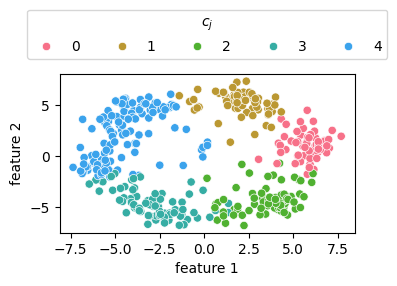

In [11]:
clusters_halfcheetah, _ = perform_clustering_and_plot(trajectory_embedding_halfcheetah.detach().cpu().numpy(), 2, 10, plot=True)